# ARIMA Model

In [53]:
# Import libraries
from pandas import read_csv
from matplotlib import pyplot
from numpy import sqrt
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [54]:
series = pd.read_excel('/content/CocaCola_Sales_Rawdata.xlsx',header=0, index_col=0, parse_dates=True)
series

,Sales
Quarter,
Q1_86,1734.827000
Q2_86,2244.960999
Q3_86,2533.804993
Q4_86,2154.962997
Q1_87,1547.818996
Q2_87,2104.411995
Q3_87,2014.362999
Q4_87,1991.746998
Q1_88,1869.049999


In [55]:
series.shape

(42, 1)

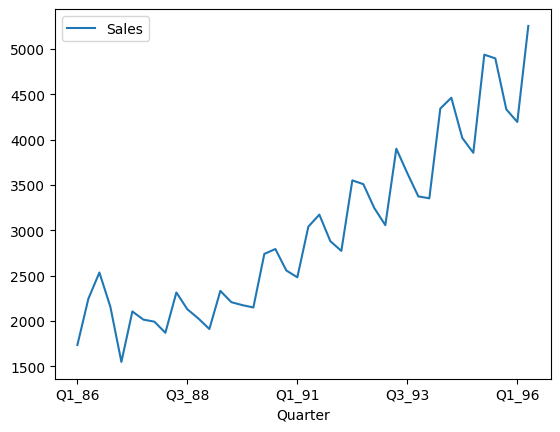

In [56]:
# line plot of time series
from pandas import read_csv
from matplotlib import pyplot
series.plot()
pyplot.show()

array([[<Axes: title={'center': 'Sales'}>]], dtype=object)

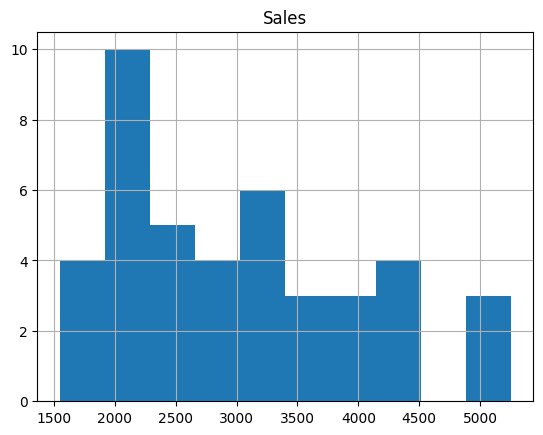

In [57]:
series.hist()

<Axes: ylabel='Density'>

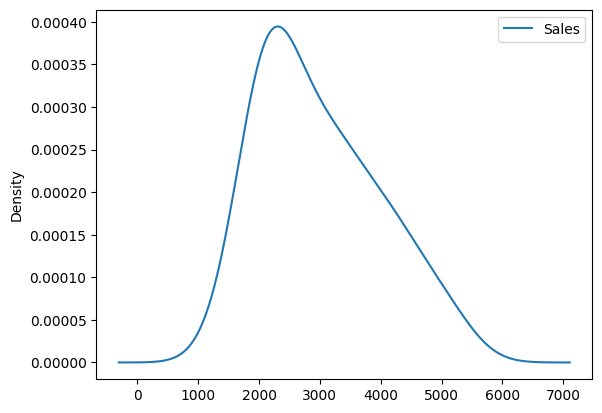

In [58]:
series.plot(kind='kde')

In [59]:
# separate out a validation dataset
split_point = len(series) - 10
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 32, Validation 10


#### Persistence/ Base model

In [60]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]


In [61]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=2173.968, Expected=2148.278
>Predicted=2148.278, Expected=2739.308
>Predicted=2739.308, Expected=2792.754
>Predicted=2792.754, Expected=2556.010
>Predicted=2556.010, Expected=2480.974
>Predicted=2480.974, Expected=3039.523
>Predicted=3039.523, Expected=3172.116
>Predicted=3172.116, Expected=2879.001
>Predicted=2879.001, Expected=2772.000
>Predicted=2772.000, Expected=3550.000
>Predicted=3550.000, Expected=3508.000
>Predicted=3508.000, Expected=3243.860
>Predicted=3243.860, Expected=3056.000
>Predicted=3056.000, Expected=3899.000
>Predicted=3899.000, Expected=3629.000
>Predicted=3629.000, Expected=3373.000
RMSE: 387.510


#### ARIMA Hyperparameters

In [62]:
# grid search ARIMA parameters for a time series

import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

#### Grid search for p,d,q values

In [63]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [64]:
# load dataset
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)

Best ARIMANone RMSE=inf


### **Build Model ARIMA**

In [65]:
!pip install pmdarima

In [66]:
# fit model
# Import the library
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")



In [67]:
# Fit auto_arima function to AirPassengers dataset
stepwise_fit = auto_arima(series['Sales'], start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise

# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=617.615, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=588.401, Time=0.27 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=617.215, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=619.036, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=590.348, Time=0.76 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=590.320, Time=0.67 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=586.466, Time=0.14 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=588.405, Time=0.56 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=588.375, Time=0.32 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   42
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -290.325
Date:                            Wed, 21 Feb 2024   AIC                            584.649
Time:                                    10:17:22   BIC                            588.076
Sample:                                         0   HQIC                           585.897
                                             - 42                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8589      0.071     12.095      0.000       0.720       0.998
sigma2        5.5e+04   1.55e+04      3.556      0.000    2.47e+04    8.53e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 1.59
Prob(Q):                              0.79   Prob(JB):                         0.45
Heteroskedasticity (H):               1.69   Skew:                             0.26
Prob(H) (two-sided):                  0.34   Kurtosis:                         2.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(series['Sales'],
                order = (0, 1, 0),
                seasonal_order =(1, 0, 0, 12))

result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   42
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -290.325
Date:                            Wed, 21 Feb 2024   AIC                            584.649
Time:                                    10:17:23   BIC                            588.076
Sample:                                         0   HQIC                           585.897
                                             - 42                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8589      0.071     12.095      0.000       0.720       0.998
sigma2        5.5e+04   1.55e+04      3.556      0.000    2.47e+04    8.53e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 1.59
Prob(Q):                              0.79   Prob(JB):                         0.45
Heteroskedasticity (H):               1.69   Skew:                             0.26
Prob(H) (two-sided):                  0.34   Kurtosis:                         2.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Quarter'>

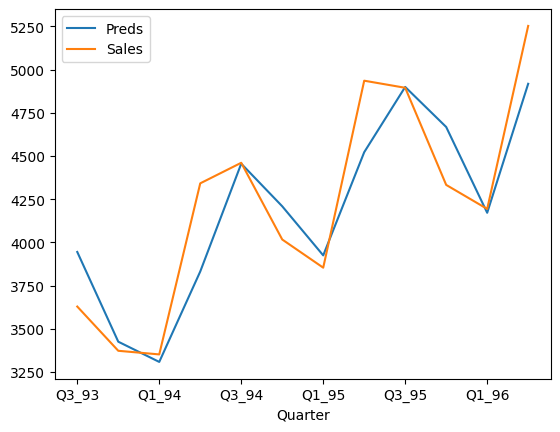

In [69]:
train = series.iloc[:len(series)-12]
test = series.iloc[len(series)-12:]


start = len(train)
end = len(train) + len(test) - 1

# Predictions for one-year against the test set
predictions = result.predict(start, end, typ = 'levels').rename("Preds")

# plot predictions and actual values
predictions.plot(legend = True)
test['Sales'].plot(legend = True)

# Data Driven Models

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

<Axes: >

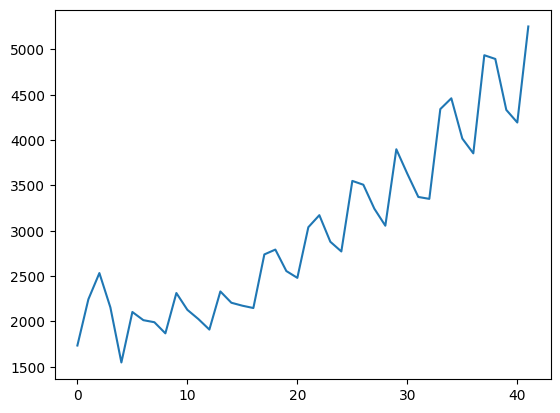

In [73]:
Walmart = pd.read_excel('/content/CocaCola_Sales_Rawdata.xlsx')
Walmart.Sales.plot()

### Splitting data

In [74]:
Train = Walmart.head(32)
Test = Walmart.tail(10)

### Moving Average

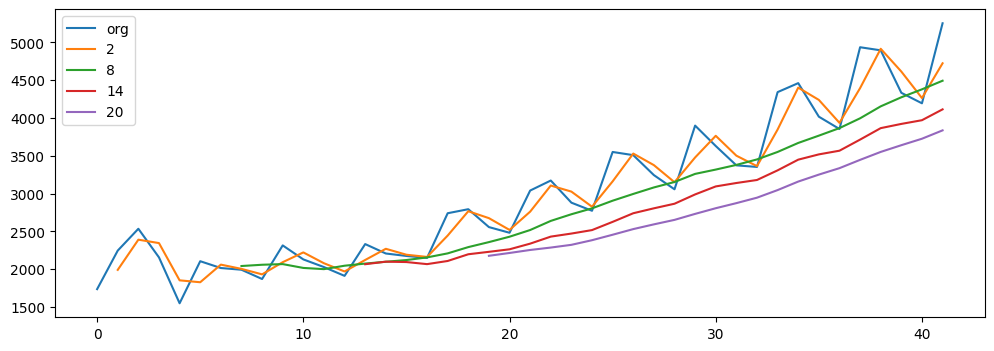

In [75]:
plt.figure(figsize=(12,4))
Walmart.Sales.plot(label="org")
for i in range(2,24,6):
    Walmart["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

### Time series decomposition plot

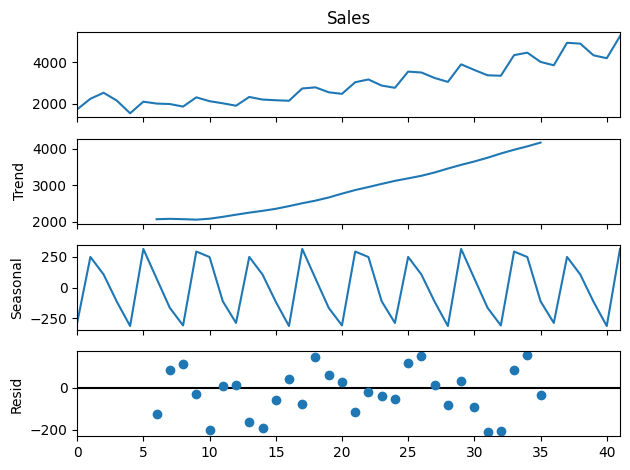

In [76]:
decompose_ts_add = seasonal_decompose(Walmart.Sales,period=12)
decompose_ts_add.plot()
plt.show()

### ACF plots and PACF plots

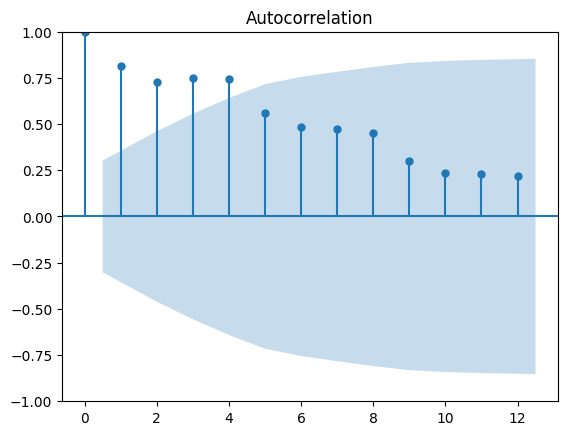

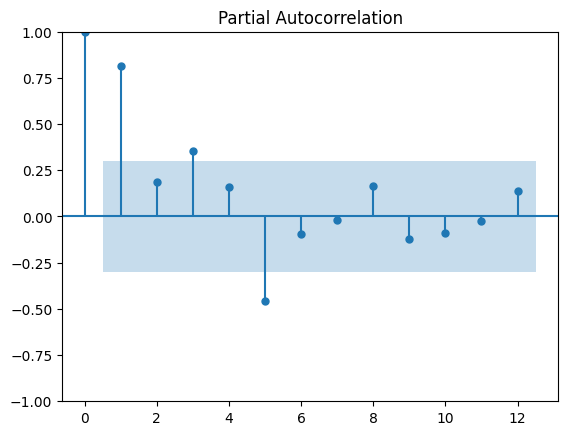

In [77]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(Walmart.Sales,lags=12)
tsa_plots.plot_pacf(Walmart.Sales,lags=12)
plt.show()

### Evaluation Metric RMSE

In [78]:
def RMSE(pred,org):
    sale=np.mean((pred-org)**2)
    return np.sqrt(sale)

### Simple Exponential Method

In [79]:
ses_model = SimpleExpSmoothing(Train["Sales"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
RMSE(pred_ses,Test.Sales)

1172.414782445301

### Holt method

In [80]:
hw_model = Holt(Train["Sales"]).fit(smoothing_level=0.2, smoothing_slope=0.8)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
RMSE(pred_hw,Test.Sales)

649.65818663435

### Holts winter exponential smoothing with additive seasonality and additive trend

In [81]:
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
RMSE(pred_hwe_add_add,Test.Sales)

719.2397912895898

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [82]:
hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
RMSE(pred_hwe_mul_add,Test.Sales)

681.5431586875204

## Final Model by combining train and tes

In [83]:
hwe_model_add_add = ExponentialSmoothing(Walmart["Sales"],seasonal="add",trend="add",seasonal_periods=12).fit()

In [84]:
#Forecasting for next 10 time periods
hwe_model_add_add.forecast(10)

42    5056.646890
43    4932.026673
44    4887.444125
45    5552.032558
46    5584.776062
47    5336.121772
48    5235.569369
49    5966.721822
50    6023.798028
51    5755.308218
dtype: float64